Using device: cpu
Total training samples: 54000
Total validation samples: 6000
Total test samples: 10000

--- Preparing HFL Data Partitions ---
Client Class Distribution (Non-IID):
  Client 0: Classes [0, 1]
  Client 1: Classes [0, 1]
  Client 2: Classes [2, 3]
  Client 3: Classes [2, 3]
  Client 4: Classes [2, 3]
  Client 5: Classes [4, 5]
  Client 6: Classes [4, 5]
  Client 7: Classes [6, 7]
  Client 8: Classes [6, 7]
  Client 9: Classes [8, 9]

--- Starting HFL Training: IID ---
Round 1/10 -> Train Acc: 97.38%, Val Acc: 97.22%
Round 2/10 -> Train Acc: 98.39%, Val Acc: 98.23%
Round 3/10 -> Train Acc: 98.81%, Val Acc: 98.60%
Round 4/10 -> Train Acc: 99.03%, Val Acc: 98.72%
Round 5/10 -> Train Acc: 99.18%, Val Acc: 98.87%
Round 6/10 -> Train Acc: 99.29%, Val Acc: 98.87%
Round 7/10 -> Train Acc: 99.43%, Val Acc: 98.93%
Round 8/10 -> Train Acc: 99.50%, Val Acc: 98.90%
Round 9/10 -> Train Acc: 99.55%, Val Acc: 98.98%
Round 10/10 -> Train Acc: 99.63%, Val Acc: 99.07%

--- Starting HFL Trai

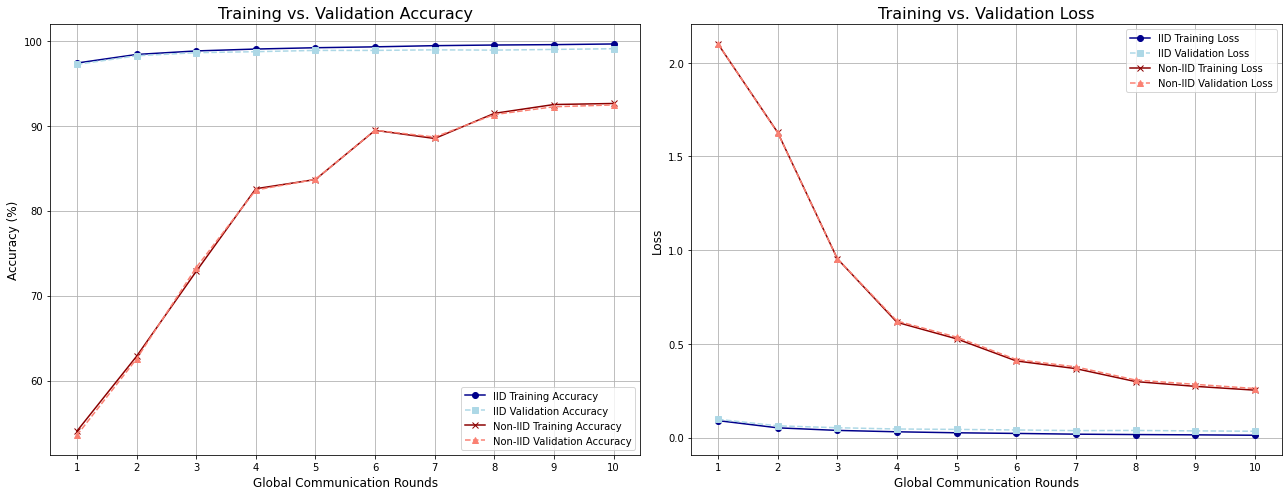


--- Generating Confusion Matrix for the Final IID Model on Test Data ---


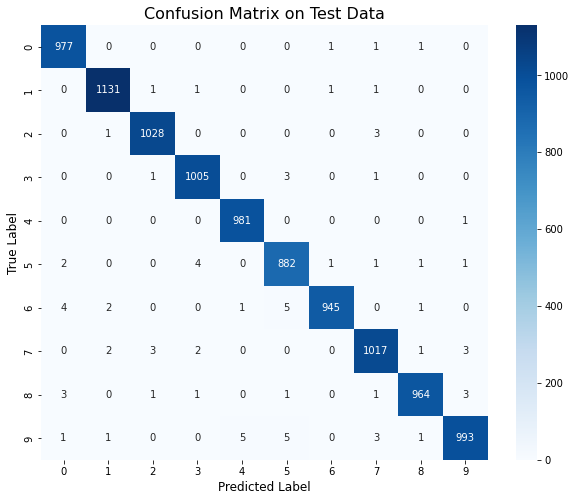

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import seaborn as sns


torch.manual_seed(42)
np.random.seed(42)

class MNIST_CNN(nn.Module):
    """A simple CNN for MNIST classification."""
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)


NUM_CLIENTS = 10
GLOBAL_ROUNDS = 10
LOCAL_EPOCHS = 2
BATCH_SIZE = 32
LEARNING_RATE = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_datasets():
    """Loads MNIST, splits train set into train and validation."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_size = int(0.9 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, val_size])
    
    print(f"Total training samples: {len(train_dataset)}")
    print(f"Total validation samples: {len(validation_dataset)}")
    print(f"Total test samples: {len(test_dataset)}")
    
    return train_dataset, validation_dataset, test_dataset


def partition_hfl_iid(dataset, num_clients):
    num_items_per_client = len(dataset) // num_clients
    client_datasets = {}
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    for i in range(num_clients):
        start_idx = i * num_items_per_client
        end_idx = start_idx + num_items_per_client
        client_indices = indices[start_idx:end_idx]
        client_datasets[i] = Subset(dataset, client_indices)
    return client_datasets

def partition_hfl_non_iid(dataset, num_clients, classes_per_client=2):
    targets = np.array(dataset.dataset.targets)[dataset.indices]
    num_classes = 10
    
    class_indices = {i: np.where(targets == i)[0] for i in range(num_classes)}
    
    client_datasets = {i: [] for i in range(num_clients)}
    client_class_map = {}
    
    class_chunks = {i: [] for i in range(num_classes)}
    for i in range(num_classes):
        np.random.shuffle(class_indices[i])
        num_clients_per_class = num_clients // (num_classes // classes_per_client)
        if num_clients_per_class == 0: num_clients_per_class = 1
        chunk_size = len(class_indices[i]) // num_clients_per_class
        if chunk_size == 0 and len(class_indices[i]) > 0: chunk_size = 1
        class_chunks[i] = [class_indices[i][j:j + chunk_size] for j in range(0, len(class_indices[i]), chunk_size)]

    client_id_counter = 0
    for class_id_start in range(0, num_classes, classes_per_client):
        class_group = list(range(class_id_start, class_id_start + classes_per_client))
        min_chunks = min(len(class_chunks[c]) for c in class_group)
        for i in range(min_chunks):
            if client_id_counter < num_clients:
                client_class_map[client_id_counter] = class_group
                indices_for_client = np.concatenate([class_chunks[c][i] for c in class_group])
                original_indices = [dataset.indices[j] for j in indices_for_client]
                client_datasets[client_id_counter] = Subset(dataset.dataset, original_indices)
                client_id_counter += 1

    print("Client Class Distribution (Non-IID):")
    for client_id, classes in client_class_map.items():
        print(f"  Client {client_id}: Classes {classes}")
    
    return client_datasets


def client_update(client_model, optimizer, train_loader, epochs):
    client_model.train()
    criterion = nn.NLLLoss()
    for e in range(epochs):
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = client_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    return client_model.state_dict()

def server_aggregate(global_model, client_models_states):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models_states[i][k].float() for i in range(len(client_models_states))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    return global_model

def evaluate_model(model, data_loader):
    model.eval()
    loss = 0
    correct = 0
    criterion = nn.NLLLoss(reduction='sum')
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    return loss, accuracy


def hfl_training_pipeline(global_model, client_datasets, train_loader, val_loader, scenario_name):
    """Main training loop for HFL, evaluating on train and validation sets."""
    print(f"\n--- Starting HFL Training: {scenario_name} ---")
    
    
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    for round_num in range(GLOBAL_ROUNDS):
        client_models_states = []
        for client_id in range(NUM_CLIENTS):
            local_model = deepcopy(global_model).to(DEVICE)
            if len(client_datasets[client_id]) > 0:
                local_loader = DataLoader(client_datasets[client_id], batch_size=BATCH_SIZE, shuffle=True)
                optimizer = optim.SGD(local_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
                updated_state_dict = client_update(local_model, optimizer, local_loader, LOCAL_EPOCHS)
                client_models_states.append(updated_state_dict)

        global_model = server_aggregate(global_model, client_models_states)
        
        
        train_loss, train_accuracy = evaluate_model(global_model, train_loader)
        val_loss, val_accuracy = evaluate_model(global_model, val_loader)
        
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f"Round {round_num+1}/{GLOBAL_ROUNDS} -> Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
        
    return history


def plot_confusion_matrix(model, data_loader, class_names):
    """Plots a confusion matrix for the given model and data."""
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix on Test Data', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()



if __name__ == '__main__':
    print(f"Using device: {DEVICE}")

    
    train_dataset, validation_dataset, test_dataset = get_datasets()
    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE*2, shuffle=False)
    val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE*2, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False)

    
    print("\n--- Preparing HFL Data Partitions ---")
    hfl_iid_datasets = partition_hfl_iid(train_dataset, NUM_CLIENTS)
    hfl_non_iid_datasets = partition_hfl_non_iid(train_dataset, NUM_CLIENTS)
    
    
    global_model_iid = MNIST_CNN().to(DEVICE)
    iid_history = hfl_training_pipeline(global_model_iid, hfl_iid_datasets, train_loader, val_loader, "IID")

    
    global_model_non_iid = MNIST_CNN().to(DEVICE)
    non_iid_history = hfl_training_pipeline(global_model_non_iid, hfl_non_iid_datasets, train_loader, val_loader, "Non-IID")

    
    print("\n--- Plotting Comparison Results ---")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    
    rounds = range(1, GLOBAL_ROUNDS + 1)
    ax1.plot(rounds, iid_history['train_accuracy'], label='IID Training Accuracy', color='darkblue', linestyle='-', marker='o')
    ax1.plot(rounds, iid_history['val_accuracy'], label='IID Validation Accuracy', color='lightblue', linestyle='--', marker='s')
    ax1.plot(rounds, non_iid_history['train_accuracy'], label='Non-IID Training Accuracy', color='darkred', linestyle='-', marker='x')
    ax1.plot(rounds, non_iid_history['val_accuracy'], label='Non-IID Validation Accuracy', color='salmon', linestyle='--', marker='^')
    ax1.set_title('Training vs. Validation Accuracy', fontsize=16)
    ax1.set_xlabel('Global Communication Rounds', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True)
    ax1.set_xticks(rounds)

    
    ax2.plot(rounds, iid_history['train_loss'], label='IID Training Loss', color='darkblue', linestyle='-', marker='o')
    ax2.plot(rounds, iid_history['val_loss'], label='IID Validation Loss', color='lightblue', linestyle='--', marker='s')
    ax2.plot(rounds, non_iid_history['train_loss'], label='Non-IID Training Loss', color='darkred', linestyle='-', marker='x')
    ax2.plot(rounds, non_iid_history['val_loss'], label='Non-IID Validation Loss', color='salmon', linestyle='--', marker='^')
    ax2.set_title('Training vs. Validation Loss', fontsize=16)
    ax2.set_xlabel('Global Communication Rounds', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True)
    ax2.set_xticks(rounds)

    plt.tight_layout()
    plt.show()

    
    print("\n--- Generating Confusion Matrix for the Final IID Model on Test Data ---")
    class_names = [str(i) for i in range(10)]
    plot_confusion_matrix(global_model_iid, test_loader, class_names)
